# Hello Deep Convolutional GAN for generating for FMNIST style images

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("TensorFlow Version: ", tf.__version__)

2025-04-01 17:09:23.679381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743552563.697548  631435 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743552563.703681  631435 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743552563.718630  631435 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743552563.718649  631435 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743552563.718651  631435 computation_placer.cc:177] computation placer alr

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Numpy Version:  2.1.3
Pandas Version:  2.2.3
TensorFlow Version:  2.19.0


The latest TensorFlow is based on Keras 3. Not everything needed for this sample is implemented in Keras 3, so need to revert back to Keras 2.  To use Keras 2.*, do the following:

- Import the `tf_keras` package.
- Set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` 

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

import tf_keras
print("tf_keras version:", tf_keras.__version__)


tf_keras version: 2.19.0


Check for GPU presence

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU detected")
else:
    print("No GPU Detected")

GPU detected


#### Get Fashion MNIST Dataset

In [4]:
# Get dataset and split into training, validation, and test sets
f_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = f_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

#### Variance Schedule

In [5]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

#### Prepare images by adding noise to them

In [6]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

#### Prepeate datasets for training and validation

In [12]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
ds_train = prepare_dataset(X_train, batch_size=32, shuffle=True)
ds_val = prepare_dataset(X_val, batch_size=32)

#### Check a few images with noise 

Original images


2025-04-01 17:23:26.871970: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


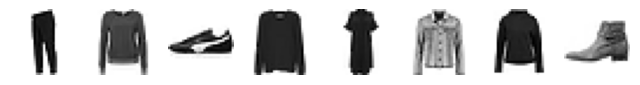

Time steps: [3405  312 3441 1991 2443 1657 3308 1151]
Noisy images


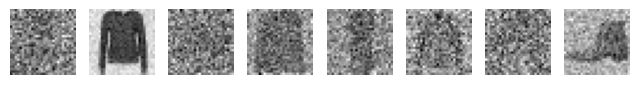

Noise to predict


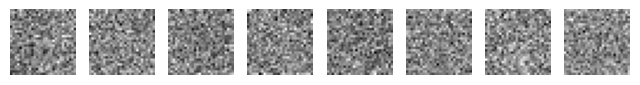

In [13]:
def viz_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(ds_train.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
viz_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
viz_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
viz_multiple_images(Y_noise[:8].numpy())
plt.show()

#### Time Encoding

In [14]:
embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

###  Build Diffusion Model

In [15]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

#### Train the Model

In [16]:
tf.random.set_seed(42) 
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# Add ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model", save_best_only=True)

history = model.fit(ds_train, validation_data=ds_val, epochs=100, callbacks=[checkpoint_cb]) 

Epoch 1/100


E0000 00:00:1743553426.716584  631435 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/huber_loss/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1743553427.471105  631912 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743553428.763041  631914 service.cc:152] XLA service 0x70f2c04126f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743553428.763060  631914 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-04-01 17:23:48.775361: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743553428.894622  631914 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - ETA: 0s - loss: 0.1036INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 49s 19ms/step - loss: 0.1036 - val_loss: 0.0699
Epoch 2/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0625INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0624 - val_loss: 0.0567
Epoch 3/100
1717/1719 [============================>.] - ETA: 0s - loss: 0.0528INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 18ms/step - loss: 0.0528 - val_loss: 0.0502
Epoch 4/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0488INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0488 - val_loss: 0.0477
Epoch 5/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0466INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0466 - val_loss: 0.0466
Epoch 6/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0454INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 33s 19ms/step - loss: 0.0454 - val_loss: 0.0443
Epoch 7/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0444INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0444 - val_loss: 0.0437
Epoch 8/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0438INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0438 - val_loss: 0.0436
Epoch 9/100
1718/1719 [============================>.] - ETA: 0s - loss: 0.0430INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0430 - val_loss: 0.0421
Epoch 10/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0426 - val_loss: 0.0422
Epoch 11/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0421 - val_loss: 0.0431
Epoch 12/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0419 - val_loss: 0.0434
Epoch 13/100
1717/1719 [============================>.] - ETA: 0s - loss: 0.0417INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0417 - val_loss: 0.0411
Epoch 14/100
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0414 - val_loss: 0.0420
Epoch 15/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0412INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0412 - val_loss: 0.0411
Epoch 16/100
1717/1719 [============================>.] - ETA: 0s - loss: 0.0409INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0409 - val_loss: 0.0409
Epoch 17/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0408 - val_loss: 0.0440
Epoch 18/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0407 - val_loss: 0.0447
Epoch 19/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0406 - val_loss: 0.0409
Epoch 20/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0405INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 18ms/step - loss: 0.0405 - val_loss: 0.0399
Epoch 21/100
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0404 - val_loss: 0.0408
Epoch 22/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0402 - val_loss: 0.0414
Epoch 23/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0401 - val_loss: 0.0417
Epoch 24/100
1718/1719 [============================>.] - ETA: 0s - loss: 0.0399INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0399 - val_loss: 0.0395
Epoch 25/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0400INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 19ms/step - loss: 0.0400 - val_loss: 0.0394
Epoch 26/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0398 - val_loss: 0.0413
Epoch 27/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0398 - val_loss: 0.0410
Epoch 28/100
1719/1719 [==============================] - 28s 17ms/step - loss: 0.0398 - val_loss: 0.0400
Epoch 29/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0396 - val_loss: 0.0396
Epoch 30/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0395 - val_loss: 0.0396
Epoch 31/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0395 - val_loss: 0.0397
Epoch 32/100
1718/1719 [============================>.] - ETA: 0s - loss: 0.0394INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0394 - val_loss: 0.0393
Epoch 33/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0393 - val_loss: 0.0396
Epoch 34/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0393INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0393 - val_loss: 0.0388
Epoch 35/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0392 - val_loss: 0.0404
Epoch 36/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0392 - val_loss: 0.0399
Epoch 37/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0391 - val_loss: 0.0392
Epoch 38/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0392 - val_loss: 0.0395
Epoch 39/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0391 - val_loss: 0.0390
Epoch 40/100
1718/1719 [============================>.] - ETA: 0s - loss: 0.0390INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0390 - val_loss: 0.0385
Epoch 41/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0390 - val_loss: 0.0392
Epoch 42/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0391 - val_loss: 0.0389
Epoch 43/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0390 - val_loss: 0.0392
Epoch 44/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0389 - val_loss: 0.0387
Epoch 45/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0390 - val_loss: 0.0393
Epoch 46/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0389 - val_loss: 0.0390
Epoch 47/100
1716/1719 [============================>.] - ETA: 0s - loss: 0.0389INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0388 - val_loss: 0.0383
Epoch 48/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0387 - val_loss: 0.0407
Epoch 49/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0387 - val_loss: 0.0388
Epoch 50/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0387 - val_loss: 0.0385
Epoch 51/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0387 - val_loss: 0.0383
Epoch 52/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0386 - val_loss: 0.0398
Epoch 53/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0386 - val_loss: 0.0387
Epoch 54/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0385INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 31s 18ms/step - loss: 0.0385 - val_loss: 0.0381
Epoch 55/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0385 - val_loss: 0.0392
Epoch 56/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0384 - val_loss: 0.0389
Epoch 57/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0386 - val_loss: 0.0386
Epoch 58/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0385 - val_loss: 0.0393
Epoch 59/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0385INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0385 - val_loss: 0.0378
Epoch 60/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0386 - val_loss: 0.0388
Epoch 61/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0384 - val_loss: 0.0384
Epoch 62/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0385 - val_loss: 0.0382
Epoch 63/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0384 - val_loss: 0.0382
Epoch 64/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0384 - val_loss: 0.0383
Epoch 65/100
1718/1719 [============================>.] - ETA: 0s - loss: 0.0383INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 66/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0384 - val_loss: 0.0396
Epoch 67/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0384 - val_loss: 0.0391
Epoch 68/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0382 - val_loss: 0.0386
Epoch 69/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0382 - val_loss: 0.0386
Epoch 70/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0382 - val_loss: 0.0381
Epoch 71/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0383 - val_loss: 0.0385
Epoch 72/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0383 - val_loss: 0.0402
Epoch 73/100
1719/1719 [==============================] - ETA: 0s - loss: 0.0381INFO:tensorflow:Assets written to: my_diffusion_model/assets


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0381 - val_loss: 0.0377
Epoch 74/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0382 - val_loss: 0.0379
Epoch 75/100
1719/1719 [==============================] - 23s 14ms/step - loss: 0.0382 - val_loss: 0.0389
Epoch 76/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0381 - val_loss: 0.0401
Epoch 77/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0381 - val_loss: 0.0378
Epoch 78/100
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0381 - val_loss: 0.0382
Epoch 79/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0381 - val_loss: 0.0382
Epoch 80/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0382 - val_loss: 0.0377
Epoch 81/100
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0382 - val_loss: 0.0380
Epoch 82/100
1719/1719 [==============================] - 2

INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 32s 18ms/step - loss: 0.0380 - val_loss: 0.0373
Epoch 89/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0380 - val_loss: 0.0384
Epoch 90/100
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0378 - val_loss: 0.0382
Epoch 91/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0380 - val_loss: 0.0375
Epoch 92/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0379 - val_loss: 0.0386
Epoch 93/100
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0379 - val_loss: 0.0379
Epoch 94/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0378 - val_loss: 0.0383
Epoch 95/100
1719/1719 [==============================] - 28s 16ms/step - loss: 0.0379 - val_loss: 0.0374
Epoch 96/100
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0378 - val_loss: 0.0382
Epoch 97/100
1719/1719 [==============================] - 2

#### Generate

t = 1    

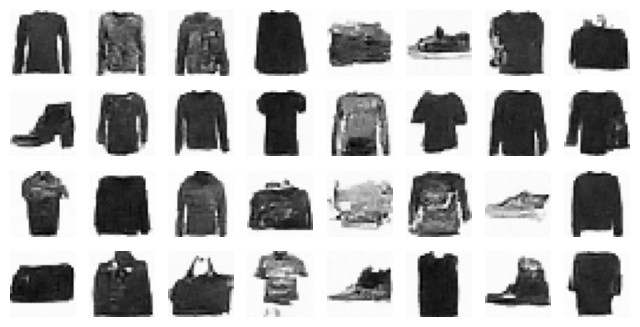

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ") 
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

X_gen = generate(model)  # generated images
viz_multiple_images(X_gen.numpy(), 8)
plt.show()